In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization

from pandas import read_csv

data = pd.read_csv(r'C:\Users\Tomas\Notebooks Python\Diplo Datos\Mentoria\rend_diario.csv',
                       index_col=0, parse_dates=True, dayfirst=True)

# data es el dataframe que contiene el rendimiento diario en dólares de todos los índices

data = data.iloc[1:5963, [2,3,4,5,6,7,8,9,10,11,12]] # le quito la primer fila que está compuesta por NAs
data

,MERV_diario,BVSP_diario,GSPC_diario,NDX_diario,FTSE_diario,GDAXI_diario,FCHI_diario,N225_diario,HSI_diario,SSEC_diario,BSESN_diario
FECHA,,,,,,,,,,,
1997-07-03,0.929826,0.086285,1.425833,1.085122,3.001574,2.039279,1.116075,0.559379,-1.485951,-4.044444,-0.213017
1997-07-04,0.772897,-31.055785,-0.131839,0.114093,3.187888,0.070745,-0.191773,-0.811322,-1.866134,-2.074027,-0.662731
1997-07-07,0.416186,47.400318,-0.383430,0.343687,-3.596321,1.398478,0.414040,-0.513522,0.589664,-2.661495,-0.161848
1997-07-08,0.541217,0.748911,0.718043,1.490356,-0.997135,0.255689,-1.014525,0.611764,-0.457160,1.170353,0.404193
1997-07-09,-0.031313,-0.085095,-1.220138,0.426520,-0.184771,-0.077669,0.709948,-0.973793,-0.590586,1.005392,2.339823
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-04,-2.619989,-3.039523,0.424983,1.329758,-0.791903,-3.437021,-3.899993,0.087080,-2.568874,0.316158,-4.582589
2020-05-05,3.579307,0.919184,0.904056,1.092467,1.816908,1.870420,1.757611,0.328444,1.076674,0.105054,-0.847475
2020-05-06,0.007127,-2.570277,-0.697941,0.607351,-0.744739,-1.559158,-1.520238,0.471099,1.144511,-0.469735,0.716138


## K-Means

El algoritmo K-means siempre suele ser el primer método de aprendizaje no supervisado que se emplea. Recibe dos parámetros: la cantidad de clusters que debe separar y el concepto de distancia según el cual debe medir qué tan alejados o cercanos están los puntos entre sí. En este caso usaremos la distancia euclidea, lo cual nos da una ventaja: dentro de cada cluster la mínima distancia entre todos los puntos de ese cluster es la media. Entonces luego se puede usar esa información para tener una noción de qué tan distintos o separados están los clusters (comparando la media de todas las observaciones con la media de cada cluster) y una noción de qué tan homogeneos o cohesivos es cada cluster (comparando la media del cluster con todas las observaciones que están en él). 

In [2]:
from tslearn.utils import to_time_series_dataset

time_series_1 = data["MERV_diario"].tolist()
time_series_2 = data["BVSP_diario"].tolist()
time_series_3 = data["FTSE_diario"].tolist()
time_series_4 = data["GDAXI_diario"].tolist()
time_series_5 = data["FCHI_diario"].tolist()
time_series_6 = data["N225_diario"].tolist()
time_series_7 = data["HSI_diario"].tolist()
time_series_8 = data["SSEC_diario"].tolist()
time_series_9 = data["BSESN_diario"].tolist()
time_series_10 = data["GSPC_diario"].tolist()
time_series_11 = data["NDX_diario"].tolist()
new_data = to_time_series_dataset([time_series_1, time_series_2, time_series_3, time_series_4, time_series_5, time_series_6,
                                            time_series_7, time_series_8, time_series_9, time_series_10, time_series_11])

El gran problema a la hora de aplicar el algoritmo K-means es saber cuántos clusters pedirle al alogitmo que separe, esto es, definir el valor de K. Generalmente para definir un hiperparámetro de este tipo se utulizaría una funcion de verosimilitud, pero al ser no supervisado el algoritmo carece de la misma. Entonces lo que se usa es una funcion de optimización interna llamada inercia. La inercia se toma como una medida de cuán coherentes son los clusters y depende directamente de K de manera negativa: mientras mayor sea el número de clusters (K) menor será la inercia del modelo. Como la inercia se define como la suma de distancias cuadradas dentro de cada cluster de la partición final, a grandes rasgos se puede decir que mientras más chica sea la inercia mejor es la clusterización. Sin embargo, como la inercia depende negativamente de K y mientras K siga aumentando la inercia seguirá disminuyendo, no tiene sentido buscar el número de clusters que minimiza la inercia, porque eso ocurrirá cuando se defina un cluster para cada observación disponible, lo cual no tiene sentido. El número de clusters óptimo, entonces, es aquel para el cual se desacelera la reducción de la inercia, porque eso significa que un K más gramde no va a mejorar las agrupaciones. 

Para saber específicamente cuál es el número de cluster que más desacelera la reducción de la inercia se suele utilizar un método gráfico como el que está a continuación, usualmente llamado "el método del codo", porque el K óptimo es aquel en el que la curva tiene un quiebre (o codo) más pronunciado. 

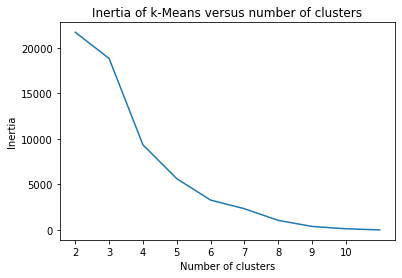

In [3]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [TimeSeriesKMeans(n_clusters=i+2, metric="euclidean").fit(new_data).inertia_ for i in range(10)]

from matplotlib import pyplot as plt
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.xticks(np.arange(2, 11, step=1)) 
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")
plt.show()

La mayor desaceleración se produce en K = 4, seguido de K = 6. Por lo tanto se probará el algoritmo K-means con 4 clusters primero y 6 despues 

In [12]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score


km = TimeSeriesKMeans(n_clusters=4, metric="euclidean")
labels = km.fit_predict(new_data)
inercia = silhouette_score(new_data, labels, metric="euclidean")

print('la inercia del modelo con 4 clusters es de:', inercia)

la inercia del modelo con 4 clusters es de: 0.2824391112970313


In [5]:
print(labels)

[2 1 3 3 3 3 3 3 3 0 0]


Las agrupaciones resultantes son bastante intuitivas. Hay dos países cuyos índices quedaron agrupados individualmente: Brasil y Argentina, que son al mismo tiempo los países que más volatilidad tuvieron en el período analizado. En otro cluster quedaron agrupados todos los índices europeos y asiáticos, lo cual tiene sentido por se relativa estabilidad a lo largo de los años y especialmente por la gran integridad que tienen esos mercados, que hace que en un dia cualquiera su rendimiento no sea muy distinto. Finalmente en el cuarto cluster quedaron juntos los índices de Estados Unidos, el Nasdaq y el SyP. No podemos atribuir este último agrupamiento al sorprendente crecimiento que tuvieron esos índices en los últimos 20 años porque estamos trabajando con rendimientos diarios, por lo tanto concluimos que el hecho de que pertenezcan al mismo cluster se debe en primer lugar a la obvia correlación que comparten ambos índices por ser del mismo país aunque no contengan a compañias del mismo rubro, y en segundo lugar a que fueron los índices con mayor cantidad de dias con rendimiento positivo de toda la muestra.

In [14]:
km2 = TimeSeriesKMeans(n_clusters=6, metric="euclidean")
labels2 = km2.fit_predict(new_data)
inercia2 = silhouette_score(new_data, labels2, metric="euclidean")

print('la inercia del modelo con 4 clusters es de:', inercia2)

la inercia del modelo con 4 clusters es de: 0.044174999715042435


In [15]:
print(labels2)

[0 2 3 1 1 5 1 4 5 5 5]


Cuando corremos el mismo algoritmo pero cambiando la cantidad de clusters que le pedimos que identifique a 6 obtenemos resultados más difíciles de interpretar. Seria un error explicar el por qué del agrupamiento resultante, ya que no estariamos haciendo más que forzar nuestra interpretación al resultado del modelo en vez de elaborar una teoría objetiva que sirva para predecir movimientos futuros de los índices. La mejor conlcusión que s epuede sacar es que nuevamente Argentina y Brasul tienen cada uno su propio cluster, lo cual indica que la divergencia que poseen los rendimientos de sus índices respecto a la de otros países es constante. Otra apreciación es que de vuelta los dos índices de Estados Unidos fueron ubicados en el mismo cluster, lo cual puede que obedezca las mismas razones explicadas en el párrafo anterior. Finalmente, se puede decir que los paises europeos que más se parecen en cuanto rendimiento son Francia y Alemania.

## Mean Shift

El algoritmo Mean Shift se basa en la densidad de los datos, porque lo que hace es evaluar el enortno de cada una de las observaciones y migrarlas hacia el centro de mayor densidad. En otras palabras, el mecanismo de este algoritmo consiste en tomar cada punto y fijarse cuántos puntos tiene en su alrededor, para luego ir moviéndolo al punto de mayor densidad que haya sido calculado para él- Una vez que identificó esas zpmas de mayor densidad, las define como "centros de atracción" y esos centros de atracción son los que generan los clusters. 

La pregunta que surge es cómo hace el algoritmo para estimar la densidad local, es decir para decidir cuáles son los centros de atracción. Los centros de atracción, y por ende la cantidad de clusters, se define de manera indirecta a través de un hiperparámetro del algoritmo llamado "bandwidth". El bandwidth es en simples palabras una medida de qué tan grande es la zona al rededor de un punto que tiene que considerar el algoritmo para buscar puntos cercanos a él. Con un bandwidth muy chico se encontrarán un monton de modas (centros de atracción) porque hay puntos que no van a encontrar vecinos y se van a quedar sólos como si fueran ellos mismos un punto de densidad local cuando en realidad no lo son. Con un bandwidth demasiado grande ocurrirá lo contrario, cada punto tendrá muchos vecinos y el algoritmo perderá precisión. 

In [16]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

ms = MeanShift(bandwidth=20, bin_seeding=True)

ms.fit(data)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero estimado de clusters para Mean Shift : %d" % n_clusters_)

# Etquetas de los elementos de los clusters

Numero estimado de clusters para Mean Shift : 4


Es una buena señal que la cantidad de clusters sugerida por el algoritmo Mean Shift coincide con la cantidad de clusters óptimos obtenida a partir de la prueba del codo. Esto quiere decir que un bandwidth de 20 es un buen valor para correr el modelo. 

## Clustering Jerárquico

El clustering jerárquico son algoritmos que generan un dendrograma en el que cada iteración o nivel se van uniendo los elementos y formando los clusters. El algoritmo de clustering jerárquico más utilizado es el aglomerativo. En el algoritmo aglomerativo, al comenzar, cada objeto (en nuestro caso cada índice) es su proprio cluster y a partir de ahí se van uniendo (aglomerando) y formando clusters más grandes. Para que esa aglomeración suceda el algoritmo requiere dos cosas, es decir dos hiperparámetros: una distancia entre los elementos (llamada "affinity") y una especificación sobre cómo se van a agrupar los clusters (llamada función de linkage). La affinity es la que va a mirar y medir los elementos y el linkage es lo que los va a unir dentro de clusters. 

In [88]:
timeseries_log = pd.read_csv(r'C:\Users\Tomas\Notebooks Python\Diplo Datos\Mentoria\serielog.csv',
                       index_col=0, parse_dates=True, dayfirst=True)
timeseries_log = timeseries_log.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]]
#timeseries_log = timeseries_log.iloc[5500:5963]
timeseries_log

,MERV,BVSP,GSPC,NDX,FTSE,GDAXI,FCHI,N225,HSI,SSEC,BSESN
FECHA,,,,,,,,,,,
1997-07-02,6.714504,9.418606,6.806863,6.883391,8.977220,8.375751,8.091117,5.172511,7.587500,4.970511,4.796275
1997-07-03,6.723759,9.419469,6.821020,6.894184,9.006794,8.395939,8.102216,5.178089,7.572529,4.929226,4.794143
1997-07-04,6.731459,9.047596,6.819701,6.895324,9.038176,8.396646,8.100296,5.169943,7.553691,4.908267,4.787493
1997-07-07,6.735612,9.435578,6.815859,6.898755,9.001550,8.410534,8.104428,5.164795,7.559571,4.881292,4.785874
1997-07-08,6.741009,9.443040,6.823014,6.913548,8.991528,8.413088,8.094231,5.170894,7.554989,4.892927,4.789907
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-04,5.685041,9.557986,7.952524,9.086376,8.875144,9.342875,8.471311,5.214559,8.021481,6.008027,6.044615
2020-05-05,5.720208,9.567136,7.961524,9.097241,8.893150,9.361406,8.488735,5.217838,8.032190,6.009077,6.036104
2020-05-06,5.720279,9.541097,7.954520,9.103296,8.885674,9.345692,8.473415,5.222538,8.043570,6.004368,6.043240


In [89]:
time_serieslog_1 = np.array(timeseries_log["MERV"])
time_serieslog_2 = np.array(timeseries_log["BVSP"])
time_serieslog_3 = np.array(timeseries_log["FTSE"])
time_serieslog_4 = np.array(timeseries_log["GDAXI"])
time_serieslog_5 = np.array(timeseries_log["FCHI"])
time_serieslog_6 = np.array(timeseries_log["N225"])
time_serieslog_7 = np.array(timeseries_log["HSI"])
time_serieslog_8 = np.array(timeseries_log["SSEC"])
time_serieslog_9 = np.array(timeseries_log["BSESN"])
time_serieslog_10 = np.array(timeseries_log["GSPC"])
time_serieslog_11 = np.array(timeseries_log["NDX"])

df = pd.DataFrame([time_serieslog_1,time_serieslog_2,time_serieslog_3,time_serieslog_4,time_serieslog_5,time_serieslog_6,
                   time_serieslog_7,time_serieslog_8,time_serieslog_9,time_serieslog_10,time_serieslog_11])

    
#serie_de_tiempo = to_time_series_dataset([time_serieslog_1, time_serieslog_2, time_serieslog_3, time_serieslog_4, time_serieslog_5, 
#                               time_serieslog_6, time_serieslog_7, time_serieslog_8, time_serieslog_9, time_serieslog_10,
#                               time_serieslog_11])



En nuestro caso la distancia que usaremos entre los elementos será el grado de correlación que existe entre ellos, mientras que la función de linkage será la que se conoce como "single-linkage". El critero de aglomeración en el single linkage es el siguiente: para cada par de clusters A y B (recordar que inicialmente cada elemento - en nuestro caso cada índice - es su propio cluster) el algoritmo se fija la distancia entre sus elementos (midiendo la distancia según la métrica que se haya elegido, que en nuestro caso es la correlación) y se queda con las distancia más pequeñam es decir busca los dos elementos que están más cerca y "guarda" esa distancia. Una vez que haya repetido ese procedimiento para todos los clusters respecto a cada uno de todos los demás va a haber quedado definida la distancia entre dos clusters como la distancia entre los puntos más cercanos de esos dos clusters, y finalmente aglomerará los clusters que tengas la más chica de esas distancias. 

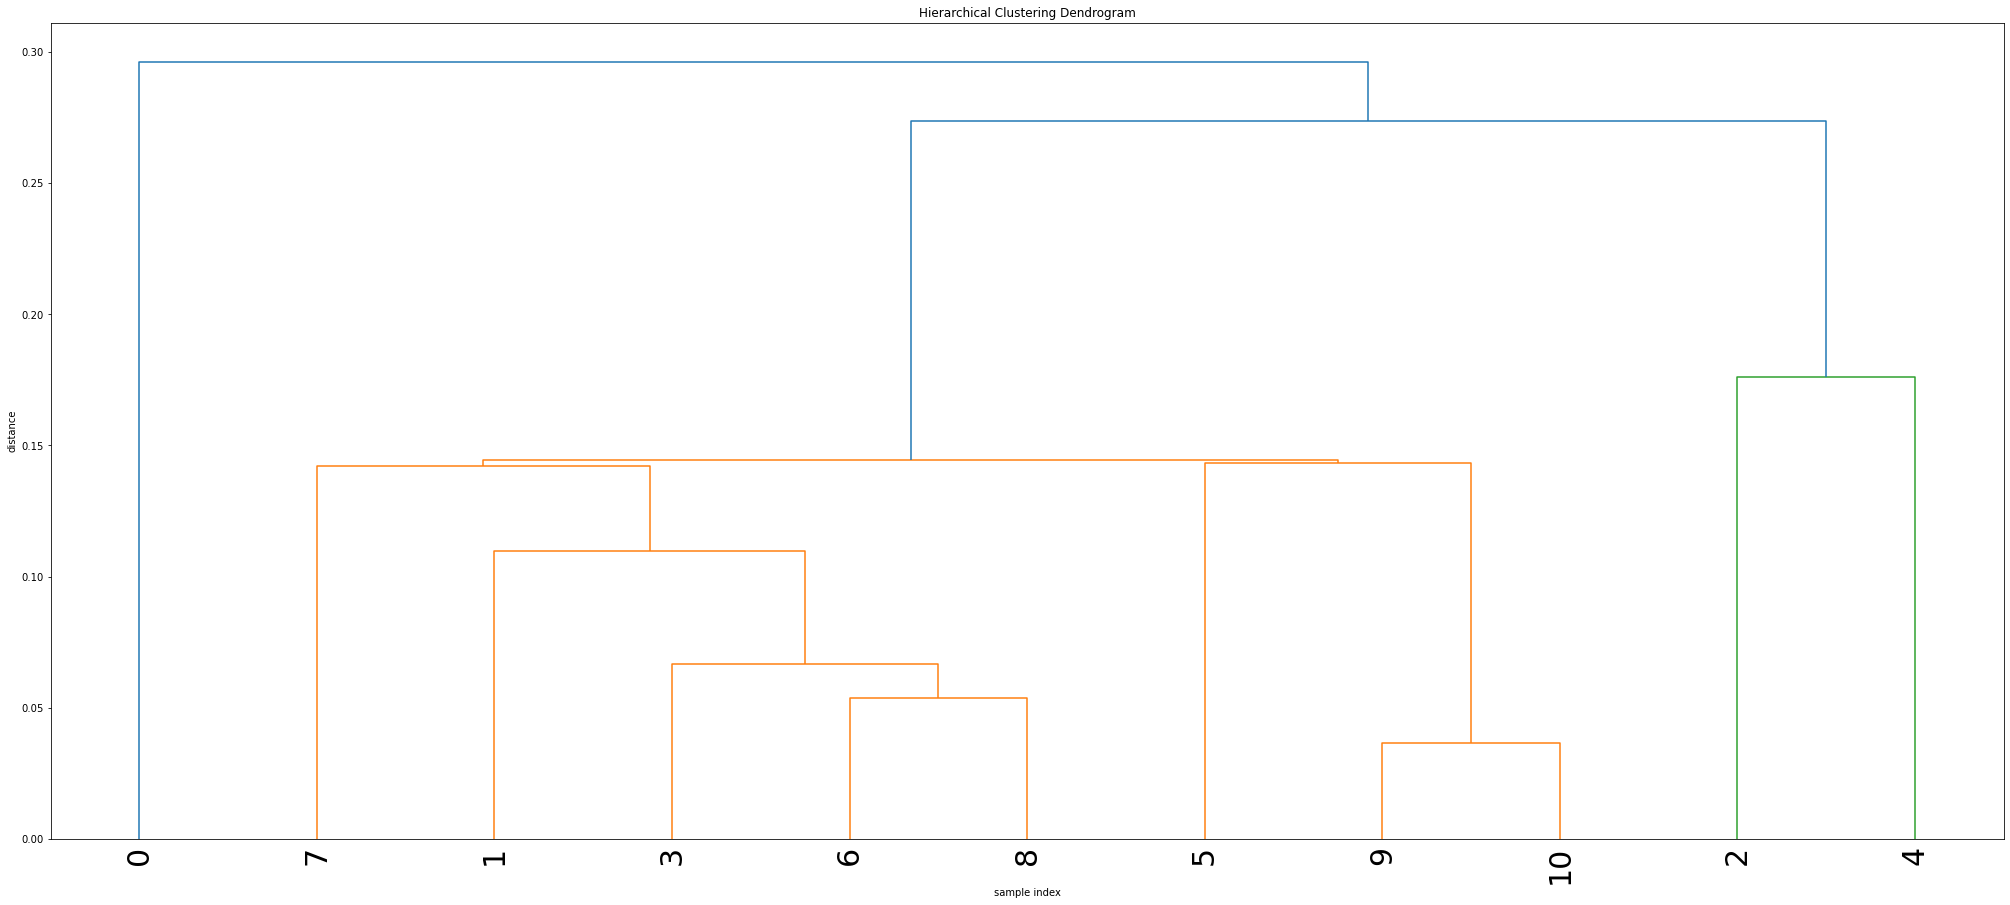

In [90]:
from scipy import stats
import scipy.cluster.hierarchy as hac

# Do the clustering
Z = hac.linkage(df, method='single', metric='correlation')

# Plot dendogram
plt.figure(figsize=(35, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
       Z,
       leaf_rotation=90.,  # rotates the x axis labels
       leaf_font_size=30.,  # font size for the x axis labels
)
plt.show()

Se puede ver que los primeros índices en ser unidos fueron el SyP 500 (9) y el Nasdaq (10), lo cual no es para nada sorprendente, además del índice de Hong Kong (6) y el de India (8). El algoritmo encontró que estos últimos dos no están muy lejos del índice de Alemania (3) y a esa terna luego se les terminaría agregando el Bovespa (1) y el índice de Shangai (7). El algoritmo terminó agrupando a todos esos índices con el Nasdaq, el SyP 500 y el Nikkei de Japón (5). 

Lo más interesante de todo es que otra vez, tal como sucedió con los algoritmos anteriores, el Merval (0) quedó en un cluster conformado únicamente por él y no fue agrupado con el índice de ningún otro país. Al parecer,la trayectoria del Merval en el período estudiado no tiene correlación con lo ocurrido en ningún otro mercado. Una sugerencia que se puede sacar de ese resultado es que a diferencia de lo que muchas veces escuchamos decirle a nuestros políticos, el constante sub desempeño de nuestra economía real y financiera no tiene mucho que ver con lo que sucede en el resto del mundo sino con los recurrentes problemas y desconfianza interna. 